**Motivation**

The  motivation  behind developingmethods  for  face  recognition  at  long  distances  is  to  enable facial recognition technology in a broaderrange of applications. One of the main applications of facial  recognition  technology  is  in  security  and  surveillance  systems,  where  it  can  be  used  to identify  and  track  individuals  in real  time.  However,  traditional  facial  recognition  systems  are typically  limited  to  recognizing  faces  at  close  distances,  which  can  be  a  limitation  in specificenvironments such as airports, train stations, borders,and other public places where individuals are often far away from the camera.Overall, the development of methods for face recognition at long  distances  is  driven  by  the  need  to  improve facial  recognition  technology'saccuracy, efficiency, and scalability in a wide range of applications.

**Problem Statement and Overview**

Face recognition is thecomputer vision problem of finding the identityof human faces in digital images or video streams.

**Project Objectives**

Extend the original arcface loss function to improve its performance for the task of face recognition in long distances

**Dataset Description**

``DroneFace`` dataset is being used for this project. Below are some details about the dataset:

- 11 subjects including 7 males and 4 females.
- a total of 2,057 pictures including 620 raw images, 1,364 frontal face images, and 73 portrait images
- The raw images are taken in 3,680x2,760 resolution with ultra-wide field of view (170°) under daylights.
- The resolutions of the facial images are between 23x31 and 384x384.
- The raw images are taken from 1.5, 3, 4, and 5 meters high.
- The raw images are taken 2 to 17 meters away from the subjects with 0.5 meters interval.



# Data Preprocessing

In [51]:
# Import the libraries

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import os.path as osp

import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F
#from sklearn.preprocessing import LabelEncoder

from model.model import Backbone
from data.data_pipe import DroneFace


## Load data

In [55]:
# Set up test directory
# Manually create a subfolder called 'test' in the main directory 
# Move subfolders 'i,j,k' into 'test'
test_dir = "data/photos_all_faces/test/"

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
# Load the test dataset
test_data = ImageFolder(root=test_dir, transform=transform)

loader = DataLoader(test_data, batch_size=1)


In [59]:
test_labels = test_data.targets
num_classes = 3

In [ ]:
# Get 10 random images and labels from the test dataset
sample_indices = random.sample(range(len(test_data)), k=10)
sample_images = [test_data[i][0] for i in sample_indices]
sample_labels = [test_data[i][1] for i in sample_indices]

# Display the 10 random images
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(sample_images[i].permute(1, 2, 0))
    ax.set_title(f"Class: {test_data.classes[sample_labels[i]]}")
    ax.axis('off')
plt.show()



# Model Evaluation

### ROC Curve

ROC (Receiver Operating Characteristic) is a curve that plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different classification thresholds. The area under the ROC curve (AUC) is often used as a measure of the overall performance of a binary classification model. 

A higher AUC indicates a better model performance in distinguishing positive and negative samples.

In [67]:
device = torch.device('cuda')
# device = torch.device('cpu')

# Load the retrained model 

model_without_pose = Backbone(50, drop_ratio=0.6, mode='ir_se').to(device) # denote this as Model 1
model_after_retrain_with_pose = Backbone(50, drop_ratio=0.6, mode='ir_se').to(device) # denote this as Model 1

model_without_pose.load_state_dict(torch.load('work_space/models/model_final_droneface.pth'))#, map_location=torch.device('cpu')))
model_after_retrain_with_pose.load_state_dict(torch.load('work_space/models/model_final_droneface_pose.pth'))


def get_image_embeddings(loader, model):
    # Set model to evaluation mode
    embeddings = []
    model.eval()
    with torch.inference_mode():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # Pass the image through the model and get the embeddings
            embedding = model(imgs)
            embeddings.append(embedding)
    return embeddings

test_embeddings_without_pose = get_image_embeddings(loader, model_without_pose)
test_embeddings_after_retrain_with_pose = get_image_embeddings(loader, model_after_retrain_with_pose)

In [68]:
# Concatenate embeddings and labels

test_embeddings_without_pose = torch.cat(test_embeddings_without_pose).detach().cpu().numpy()
test_embeddings_after_retrain_with_pose = torch.cat(test_embeddings_after_retrain_with_pose).detach().cpu().numpy()
test_labels = np.array(test_labels)

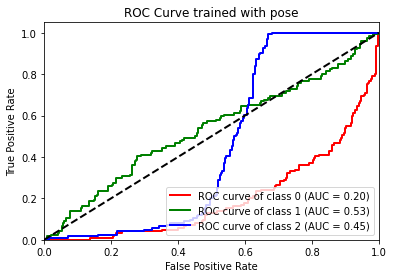

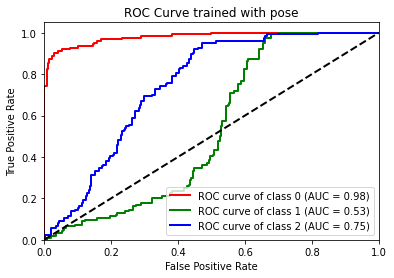

In [70]:
test_embeddings = [test_embeddings_without_pose, test_embeddings_after_retrain_with_pose]

for i, embeddings_set in enumerate(test_embeddings):
# Compute the ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, embeddings_set[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #
    plt.figure()
    lw = 2
    colors = ['red', 'green', 'blue']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (AUC = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    if i == 0:
        title = f'ROC Curve trained without pose'
    else:
        title = f'ROC Curve trained with pose'
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Discussion

From the plots, it can be observed that our proposed model significantly outperform the original ArcFace model. Specifically, AUC of class 0 increases by 78% while that of class 2 increases by 30%

### Cumulative Matching Characteristics (CMC) curve

The Cumulative Matching Characteristics (CMC) curve is a graph that shows the recognition performance of a biometric system as a function of the rank of the correct match. It is commonly used to evaluate the performance of face recognition systems.

The CMC curve is obtained by ranking the test images based on their similarity scores with the gallery images, from the highest to the lowest. Then, for each rank, we compute the proportion of test images that have been correctly identified as a match to a gallery image among the top K matches. The CMC curve plots the cumulative proportion of correct matches up to rank K, for different values of K.

For example, at rank 1, the CMC curve shows the proportion of test images that have been correctly identified as a match to their corresponding gallery image. At rank 5, the CMC curve shows the proportion of test images that have been correctly identified as a match to their corresponding gallery image among the top 5 matches. The CMC curve is useful for comparing the performance of different face recognition models, and for determining the rank at which the recognition performance starts to degrade.


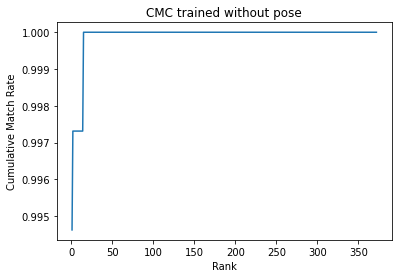

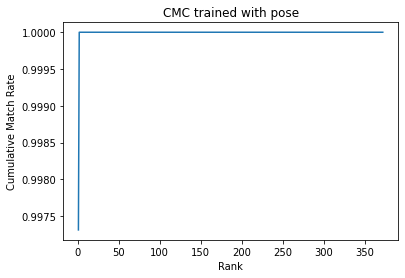

In [72]:
# Compute similarity scores between embeddings

for r, embeddings_set in enumerate(test_embeddings):

    similarity_scores = np.dot(embeddings_set, embeddings_set.T)

    # Initialize variables for keeping track of matches
    num_matches = len(test_labels)
    matches_at_ranks = np.zeros(num_matches)
    rank_scores = np.zeros(num_matches)

    # Loop through each query image and compute matches at each rank
    for i in range(num_matches):
        # Sort similarity scores in descending order and get corresponding indices
        sorted_indices = np.argsort(-similarity_scores[i])
        
        # Get labels of the top k images (excluding the query image)
        k = num_matches - 1
        top_k_labels = test_labels[sorted_indices[1:k+1]]
        
        # Check if the query image matches any of the top k images at each rank
        for j in range(k):
            if top_k_labels[j] == test_labels[i]:
                matches_at_ranks[j] += 1
                break
    
    if r == 0:
        title = f'CMC trained without pose'
    else:
        title = f'CMC trained with pose'
    # Compute cumulative matches at each rank and plot the CMC curve
    cmc = np.cumsum(matches_at_ranks) / num_matches
    plt.plot(range(1, num_matches+1), cmc)
    plt.xlabel('Rank')
    plt.ylabel('Cumulative Match Rate')
    plt.title(title)
    plt.show()


### Discussion

From the plots, it can be observed that our proposed method improves the performance of the model with a 1.0 cummulative match rate at Rank-1 Accuracy